In [1]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
url = 'https://raw.github.com/ssujit/move_sustainable/main/data/'

# variable declaration
wkam = 'wkamo_hdn.gpkg' # wkamo: weekdays peak-traffic morning hours (6:00-8:59) 
wkpm = 'wkpmo_hdn.gpkg' # wkpmo: weekdays peak-traffic afternoon hours (14:00-16:59) 
satam = 'satamo_hdn.gpkg' # satamo: Saturday peak-traffic morning hours (6:00-8:59) 
satpm = 'satpmo_hdn.gpkg' # satpmo: Saturday peak-traffic afternoon hours (14:00-16:59)  
sunam = 'sunamo_hdn.gpkg' # sunamo: Saturday peak-traffic morning hours (6:00-8:59)
sunpm = 'sunamo_hdn.gpkg' # sunpmo: Saturday peak-traffic afternoon hours (14:00-16:59) 

#read the files
wk_am = gpd.read_file(f'{url}{wkam}')
wk_pm = gpd.read_file(f'{url}{wkpm}')
sat_am = gpd.read_file(f'{url}{satam}')
sat_pm = gpd.read_file(f'{url}{satpm}')
sun_am = gpd.read_file(f'{url}{sunam}')
sun_pm = gpd.read_file(f'{url}{sunpm}')

In [3]:
wk_am.head()

,VALUE,grid_name,net_dis,perH_sum,pti,geometry
0,768.94497,2,769,24.665,0.032076,"POLYGON ((354747.343 5672460.510, 355828.624 5..."
1,855.81989,3,856,9.000,0.010516,"POLYGON ((355828.624 5672460.510, 356909.906 5..."
2,988.74922,4,989,NaN,NaN,"POLYGON ((356909.906 5672460.510, 357991.187 5..."
3,707.28729,5,707,12.000,0.016966,"POLYGON ((353666.061 5671273.733, 354747.343 5..."
4,166.20974,6,166,61.335,0.369022,"POLYGON ((354747.343 5671273.733, 355828.624 5..."


<Axes: xlabel='pti', ylabel='Density'>

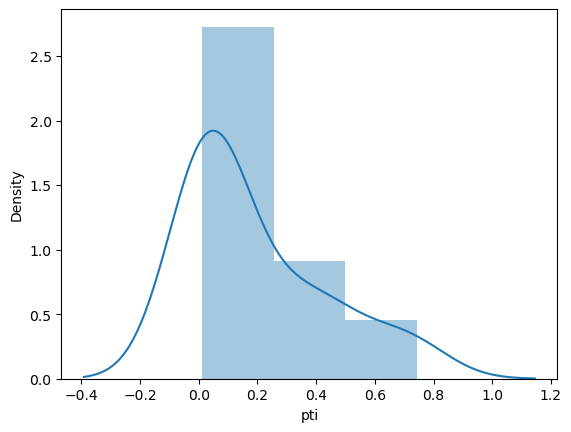

In [4]:
sns.distplot(wk_am['pti'])

<Axes: >

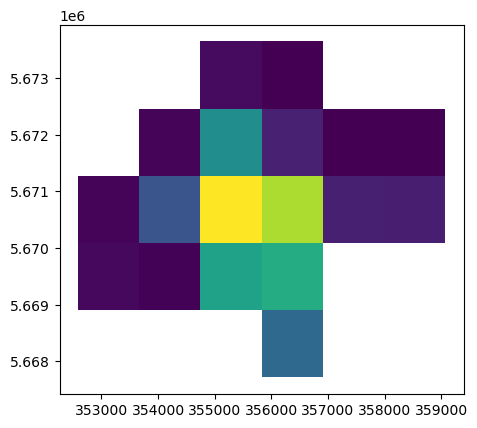

In [5]:
wk_am.plot("pti")

<Axes: >

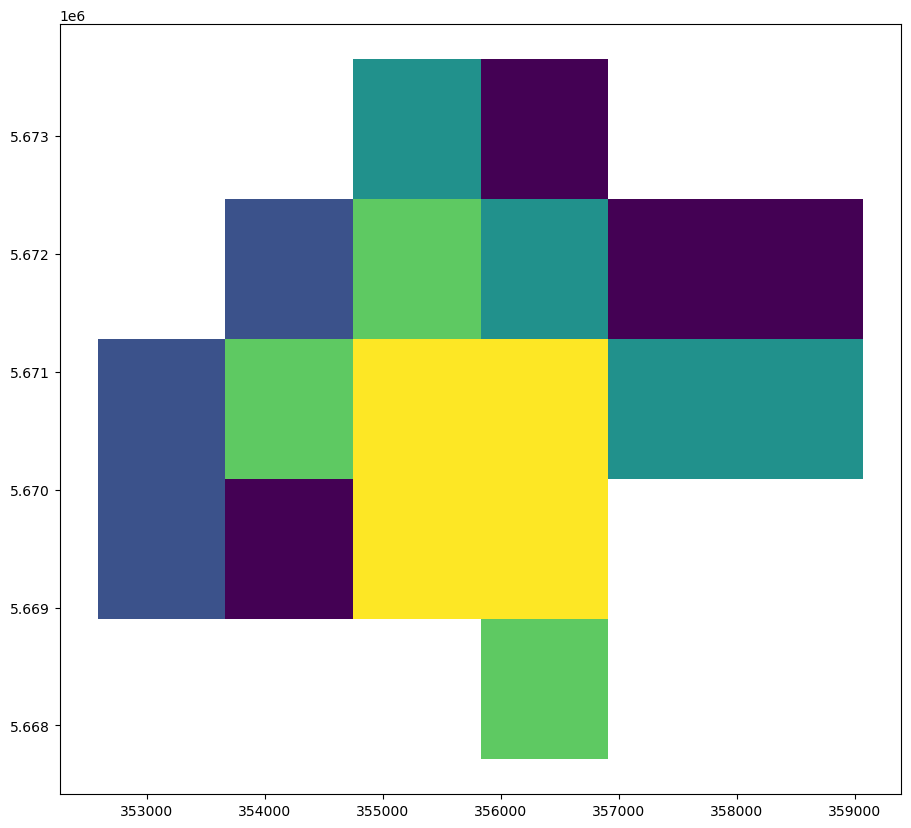

In [6]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
wk_am.plot(column='pti', scheme='Quantiles', ax=ax)

<Axes: >

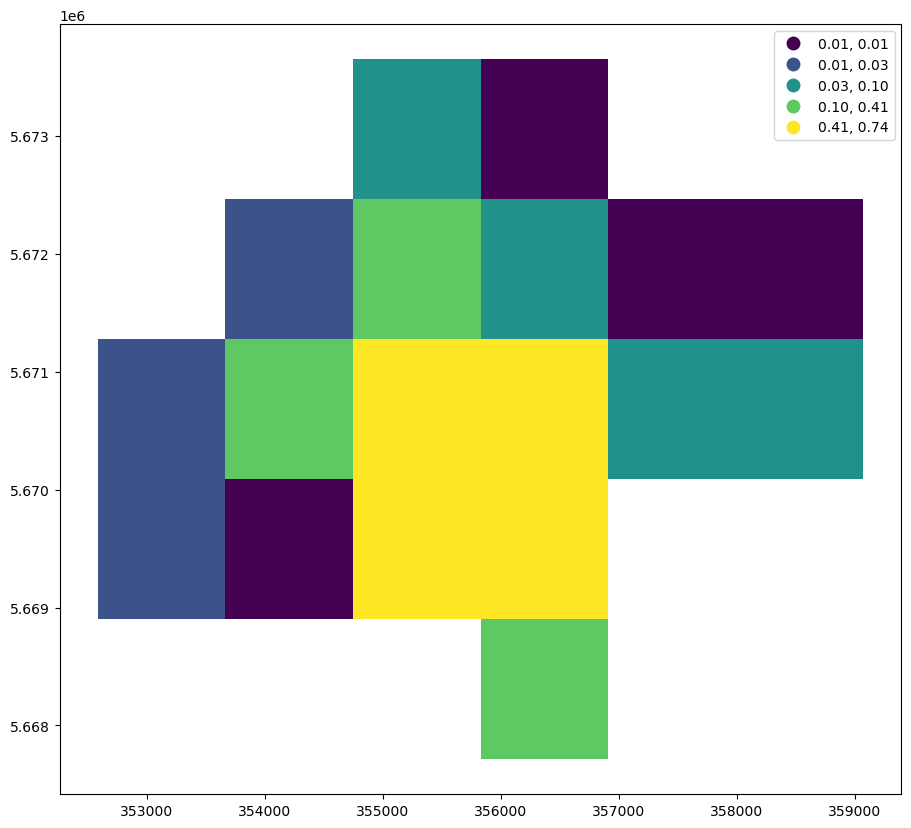

In [7]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
wk_am.plot(column='pti', scheme='Quantiles', legend= True, ax=ax)

<Axes: >

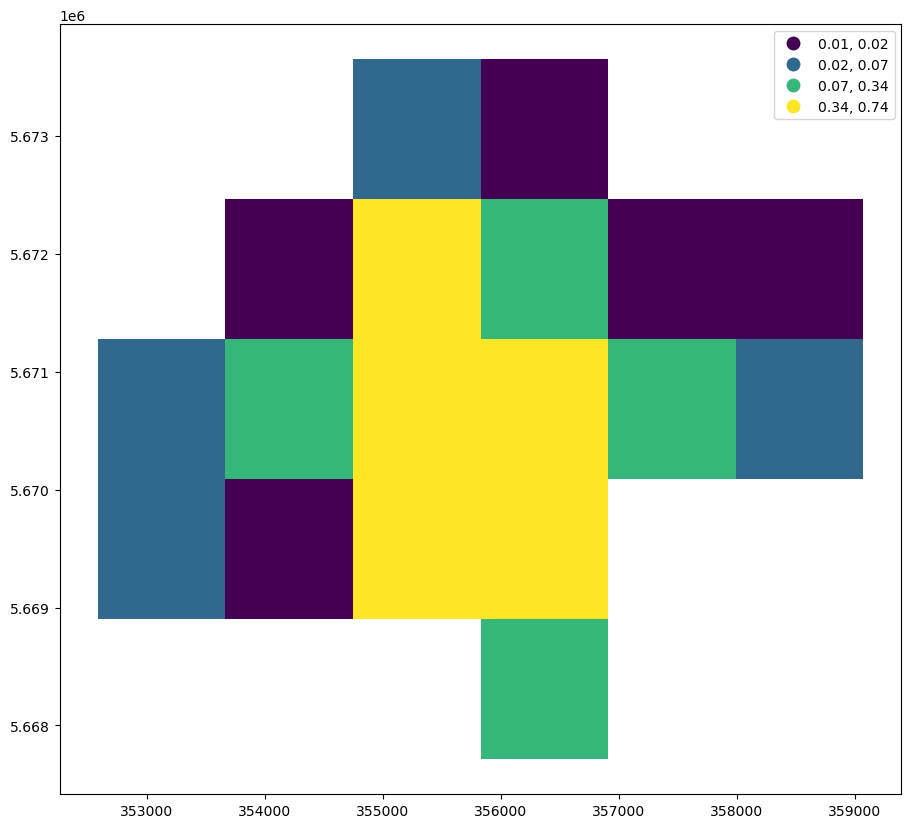

In [8]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
wk_am.plot(column='pti', scheme='Quantiles', k= 4, legend= True, ax=ax)

<Axes: >

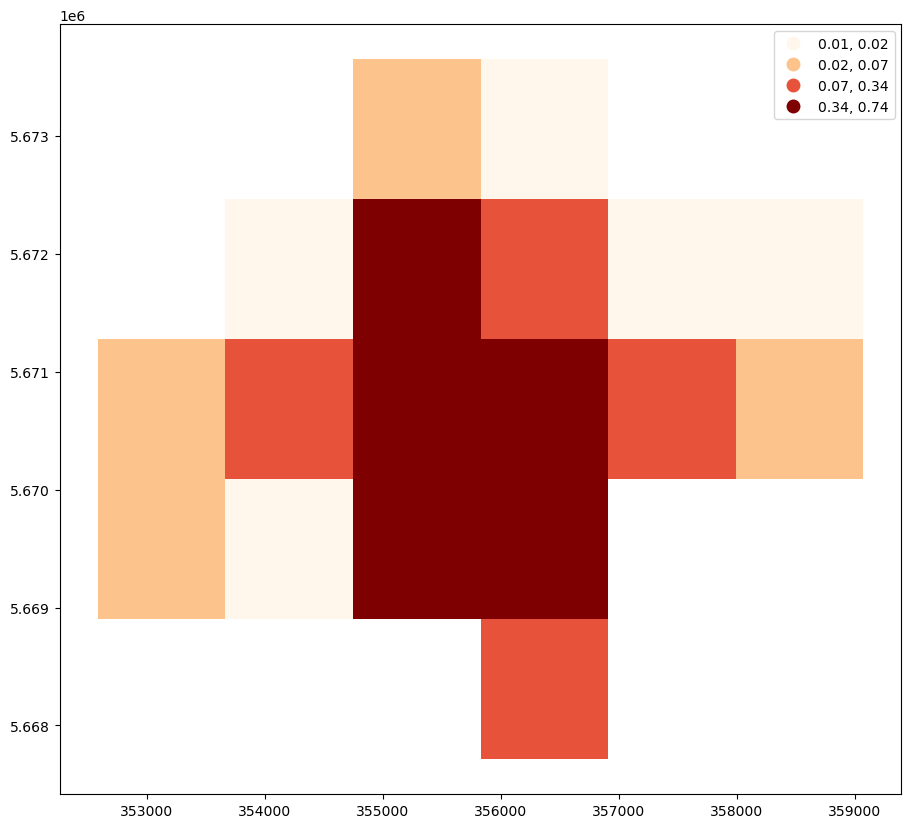

In [9]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
wk_am.plot(column='pti', scheme='Quantiles', k= 4, legend= True, cmap= 'OrRd', ax=ax)

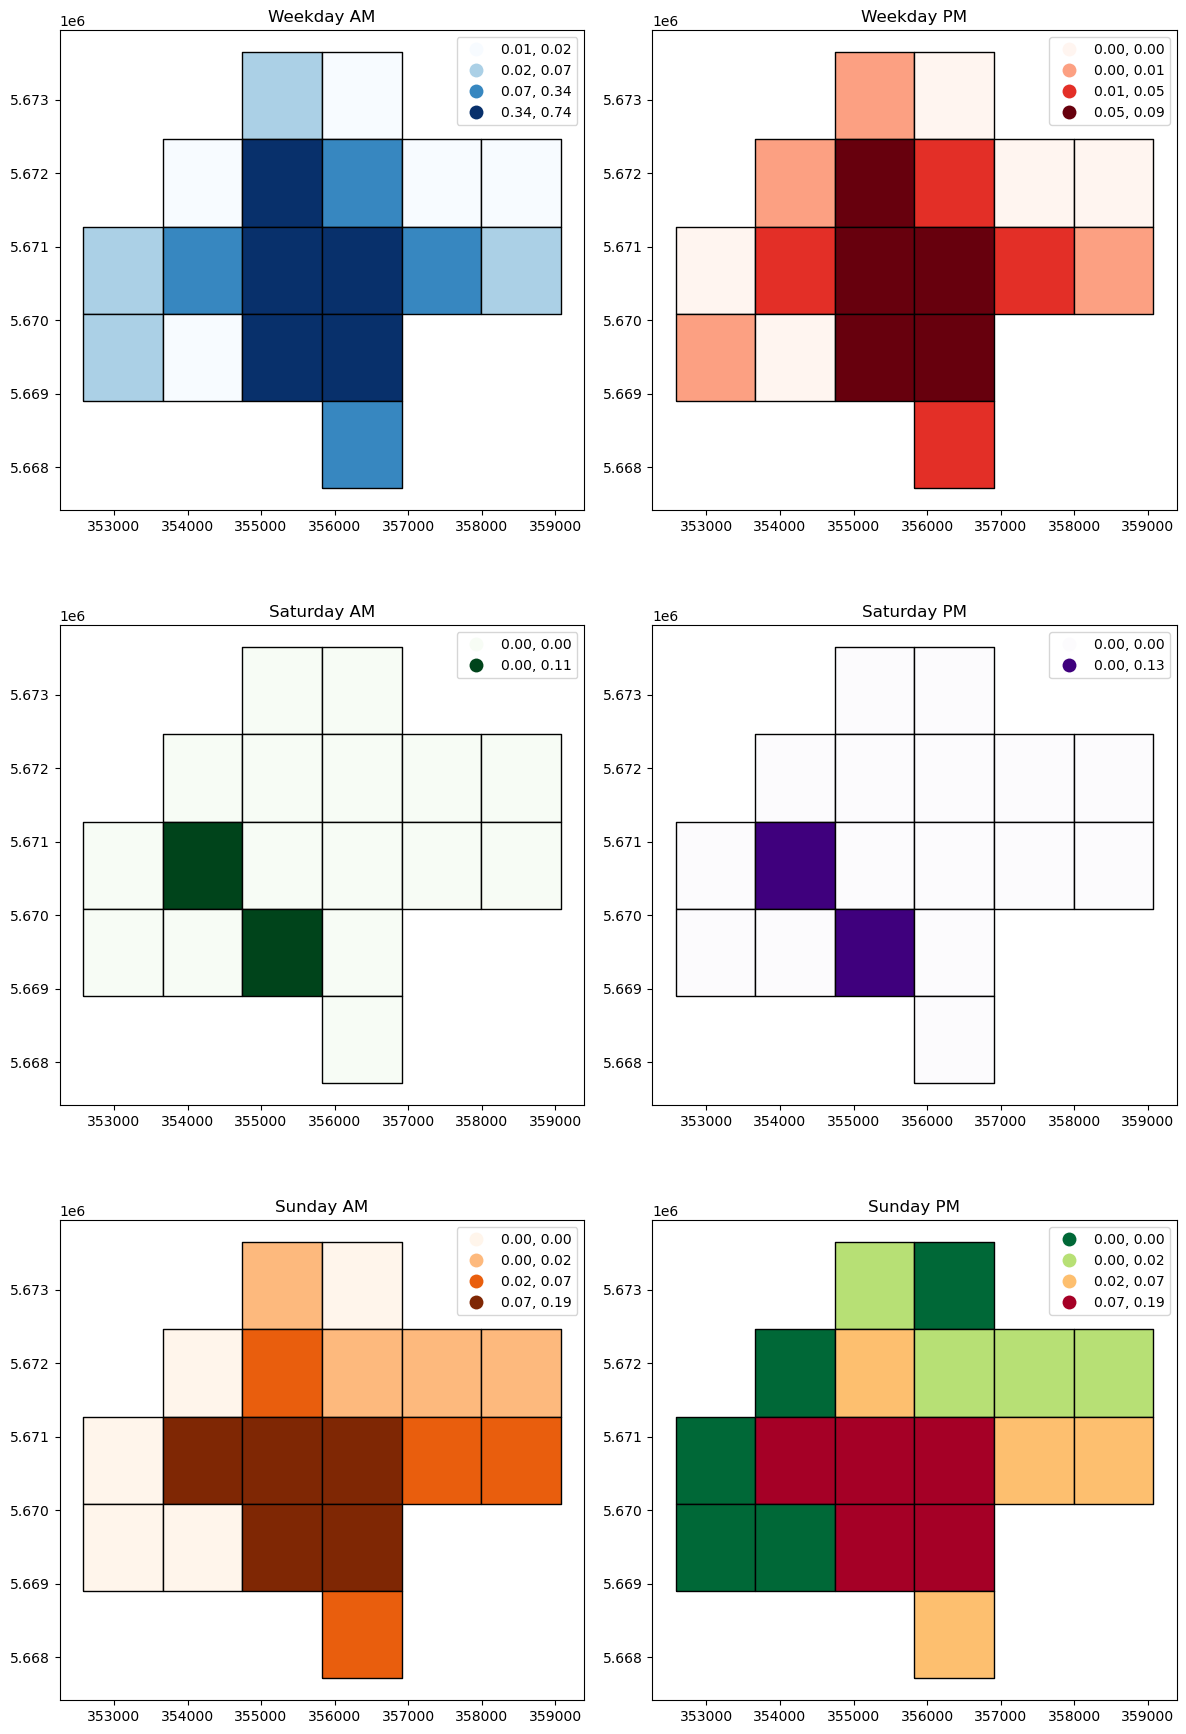

In [10]:
# Set up subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 18), subplot_kw=dict(aspect='equal'))

wk_am.plot("pti", cmap="Blues", scheme='Quantiles', k= 4, edgecolor='k', legend=True, ax=axes[0, 0])
axes[0, 0].set_title("Weekday AM")

wk_pm.plot("pti", cmap="Reds", scheme='Quantiles', k= 4, edgecolor='k', legend=True, ax=axes[0, 1])
axes[0, 1].set_title("Weekday PM")

sat_am.plot("pti", cmap="Greens", scheme='Quantiles', k= 4, edgecolor='k', legend=True, ax=axes[1, 0])
axes[1, 0].set_title("Saturday AM")

sat_pm.plot("pti", cmap="Purples", scheme='Quantiles', k= 4, edgecolor='k', legend=True, ax=axes[1, 1])
axes[1, 1].set_title("Saturday PM")

sun_am.plot("pti", cmap="Oranges", scheme='Quantiles', k= 4, edgecolor='k',legend=True, ax=axes[2, 0])
axes[2, 0].set_title("Sunday AM")

sun_pm.plot("pti", cmap="RdYlGn_r", scheme='Quantiles', k= 4, edgecolor='k', legend=True, ax=axes[2, 1])
axes[2, 1].set_title("Sunday PM")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
import mapclassify as mc

In [ ]:
pd.